In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [67]:


np.random.seed(42)


num_samples = 5000


total_flights = np.random.randint(10, 200, size=num_samples)
num_cancellations = np.random.randint(0, total_flights + 1, size=num_samples)
time_since_booking = np.random.randint(1, 60, size=num_samples)
season_cancelled = np.random.randint(0, 2, size=num_samples)


prob_cancel = (num_cancellations / total_flights) + (1 / total_flights)
prob_cancel = np.clip(prob_cancel, 0, 1)

prob_cancel += (time_since_booking < 10) * 0.2
prob_cancel = np.clip(prob_cancel, 0, 1)


cancel_label = np.random.binomial(1, prob_cancel)


df = pd.DataFrame({
    'total_flights': total_flights,
    'num_cancellations': num_cancellations,
    'time_since_booking': time_since_booking,
    'season_cancelled': season_cancelled,
    'cancel_label': cancel_label
})
df = df.sample(frac=1).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)
print(df.head())


   total_flights  num_cancellations  time_since_booking  season_cancelled  \
0             93                 42                  26                 0   
1             95                 81                  12                 1   
2             40                 29                  26                 1   
3            190                101                  29                 1   
4             78                 62                  48                 1   

   cancel_label  
0             0  
1             1  
2             0  
3             1  
4             1  


In [68]:
X = torch.tensor(df[['total_flights', 'num_cancellations', 'time_since_booking', 'season_cancelled']].values, dtype=torch.float32)
y = torch.tensor(df['cancel_label'].values, dtype=torch.float32).view(-1, 1)

In [69]:
print(X)

tensor([[93., 42., 26.,  0.],
        [95., 81., 12.,  1.],
        [40., 29., 26.,  1.],
        ...,
        [64., 64., 36.,  0.],
        [75., 32., 33.,  0.],
        [44., 23., 19.,  1.]])


Cross-validation batch 1/5
Epoch 1/15, Loss: 0.3970, Val Loss: 0.5224, Val Accuracy: 0.7675
Epoch 2/15, Loss: 0.3426, Val Loss: 0.5177, Val Accuracy: 0.7612
Epoch 3/15, Loss: 0.3979, Val Loss: 0.5267, Val Accuracy: 0.7600
Epoch 4/15, Loss: 0.3626, Val Loss: 0.5027, Val Accuracy: 0.7800
Epoch 5/15, Loss: 0.3447, Val Loss: 0.4922, Val Accuracy: 0.7750
Epoch 6/15, Loss: 0.3296, Val Loss: 0.5009, Val Accuracy: 0.7550
Epoch 7/15, Loss: 0.3226, Val Loss: 0.4833, Val Accuracy: 0.7863
Epoch 8/15, Loss: 0.3748, Val Loss: 0.5081, Val Accuracy: 0.7712
Epoch 9/15, Loss: 0.3136, Val Loss: 0.4927, Val Accuracy: 0.7738
Epoch 10/15, Loss: 0.3161, Val Loss: 0.4956, Val Accuracy: 0.7512
Epoch 11/15, Loss: 0.3514, Val Loss: 0.4875, Val Accuracy: 0.7788
Epoch 12/15, Loss: 0.3743, Val Loss: 0.5026, Val Accuracy: 0.7712
Epoch 13/15, Loss: 0.3038, Val Loss: 0.4842, Val Accuracy: 0.7712
Epoch 14/15, Loss: 0.3890, Val Loss: 0.5220, Val Accuracy: 0.7612
Epoch 15/15, Loss: 0.3206, Val Loss: 0.5024, Val Accuracy:

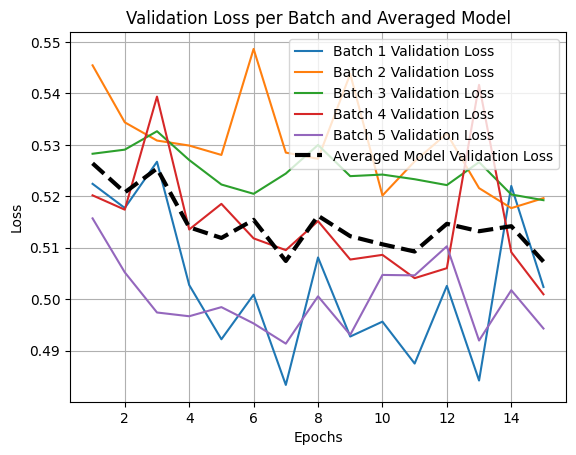

Final Test Accuracy: 0.5410


In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

X = torch.tensor(df[['total_flights', 'num_cancellations', 'time_since_booking', 'season_cancelled']].values, dtype=torch.float32)
y = torch.tensor(df['cancel_label'].values, dtype=torch.float32).view(-1, 1)

num_batches = 5
train_val_size = int(0.8 * len(df))
test_size = len(df) - train_val_size
val_size = train_val_size // num_batches

X_val_train, X_test = X[:train_val_size], X[train_val_size:]
y_val_train, y_test = y[:train_val_size], y[train_val_size:]

class FlightCancellationNN(nn.Module):
    def __init__(self):
        super(FlightCancellationNN, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

weights_list = []
batch_losses = []
val_losses = []

for i in range(num_batches):
    print(f'Cross-validation batch {i+1}/{num_batches}')

    X_val = X_val_train[i * val_size : (i + 1) * val_size]
    y_val = y_val_train[i * val_size : (i + 1) * val_size]

    X_train = torch.cat([X_val_train[:i * val_size], X_val_train[(i + 1) * val_size:]], dim=0)
    y_train = torch.cat([y_val_train[:i * val_size], y_val_train[(i + 1) * val_size:]], dim=0)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    model = FlightCancellationNN()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 15
    best_val_loss = float('inf')
    best_weights = None
    batch_loss = []
    val_loss_list = []

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
                predicted = (y_pred > 0.5).float()
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct / total
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        batch_loss.append(loss.item())
        val_loss_list.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.state_dict()

    batch_losses.append(batch_loss)
    val_losses.append(val_loss_list)
    weights_list.append(best_weights)
    plt.plot(range(1, epochs + 1), val_loss_list, label=f'Batch {i+1} Validation Loss')

avg_weights = {}
for key in weights_list[0]:
    avg_weights[key] = sum(w[key] for w in weights_list) / num_batches

model.load_state_dict(avg_weights)

avg_losses = np.mean(val_losses, axis=0)
plt.plot(range(1, epochs + 1), avg_losses, label='Averaged Model Validation Loss', linewidth=3, linestyle='--', color='black')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss per Batch and Averaged Model')
plt.legend()
plt.grid()
plt.show()

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        predicted = (y_pred > 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

print(f'Final Test Accuracy: {correct / total:.4f}')


In [73]:
input_data = torch.tensor([[100, 69, 100, 2]], dtype=torch.float32)
model.eval()
with torch.no_grad():
    prediction = model(input_data)  # Получаем вероятность отмены
    predicted_label = (prediction > 0.5).float()  # Превращаем в 0 или 1

print(f'Предсказанная вероятность отмены: {prediction.item():.4f}')
print(f'Предсказанный класс (0 - не отменит, 1 - отменит): {int(predicted_label.item())}')

Предсказанная вероятность отмены: 0.7600
Предсказанный класс (0 - не отменит, 1 - отменит): 1
